# Figure 5 - Correlation wavefield contribution of an isolated secondary microseism source

This notebook reproduces Figure 5 of Schippkus et al. 2023 ("Repeating direct waves in the coda of ambient seismic noise cross correlations"). It computes the source time function for the secondary microseism mechanism, following Gualtieri et al. 2020, and its contribution to the correlation wavefield.

In [1]:
import numpy as np
from scipy.signal import fftconvolve
from obspy import read_inventory
from obspy.geodetics import gps2dist_azimuth
from obspy.signal.util import util_geo_km

# Fixed seed for reproduction of manuscript
np.random.seed(42)

# Define time
freq = 10
timelen = 1200
times = np.arange(0, timelen + 1 / freq, 1 / freq)

c = "#3f90da"

# Define geometry
master_station = np.array([-75, -200])
inv = read_inventory("../meta/graefenberg.stationxml")
array_stations_latlon = np.array([(sta.longitude, sta.latitude) for sta in inv[0]])

isolated_source = np.array([-200, 150])

array_stations = []
for sta in array_stations_latlon:
    array_stations.append(
        util_geo_km(
            np.mean(array_stations_latlon[:, 0]),
            np.mean(array_stations_latlon[:, 1]),
            sta[0],
            sta[1],
        )
    )
array_stations = np.array(array_stations)
station = array_stations[0]

dist_master = np.linalg.norm(master_station - isolated_source)
dist_station = np.linalg.norm(station - isolated_source)

# Define medium
# acoustic, isotropic, homogeneous half-space
vel = 3

# Compute secondary microseism source time function

lapsetimes = times - times[-1] / 2
# harmonic frequencies excited and their phases
freqs = np.fft.fftfreq(len(times), 1 / freq)
freqs_excited = freqs[np.where((freqs > 0.1) & (freqs < 0.4))]
phases = np.random.uniform(0, 2 * np.pi, size=freqs_excited.shape)

# source time function is sum over harmonics in frequency range
# eq. 4 in Schippkus et al. 2023, with A=1
stf = P = np.sum(
    [
        np.cos(2 * np.pi * freqs_excited[i] * times + phases[i])
        for i in range(freqs_excited.shape[0])
    ],
    axis=0,
)

# Auto-correlation of source time function,
stf_acorr = fftconvolve(stf, stf[::-1], mode="same")
# normalised for plotting simplicity
stf_acorr /= np.max(np.abs(stf_acorr))

# Green's functions = Dirac delta functions
gf_master = np.zeros(len(times))
gf_master[int(freq * dist_master / vel)] = 1
gf_station = np.zeros(len(times))
gf_station[int(freq * dist_station / vel)] = 1

# Correlation
gf_corr = fftconvolve(gf_station, gf_master[::-1], mode="same")

# Isolated noise source contribution to the correlation wavefield
# second term of eq. 2, Schippkus et al. 2023
isolated_source_contribution = fftconvolve(stf_acorr, gf_corr, mode="same")

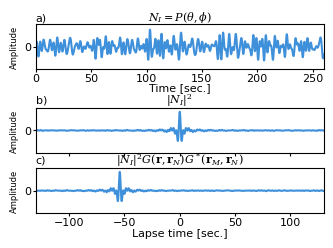

In [2]:
# Plot results
import pylab as plt

c = "#3f90da"

_cm = 1 / 2.54
plt.rc("font", size=8)
plt.rc("axes", titlesize=8)
plt.rc("axes", labelsize=8)
plt.rc("xtick", labelsize=8)
plt.rc("ytick", labelsize=8)
plt.rc("legend", fontsize=8)
plt.rcParams["mathtext.fontset"] = "dejavuserif"

fig, axs = plt.subplots(3, 1, figsize=(8.6 * _cm, 6 * _cm))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.125, top=0.925, hspace=0.6)

for ax in axs:
    ax.xaxis.set_tick_params(length=2, pad=1)
    ax.yaxis.set_tick_params(length=2, pad=1)

# Source time function
ax = axs[0]
stf /= np.max(np.abs(stf))
ax.plot(times, stf, c=c)
ax.set_xlim(0, 260)
ax.set_xticks(np.arange(0, 250 + 50, 50))
ax.set_xlabel("Time [sec.]", labelpad=-1)
ax.set_ylim(-1.2, 1.2)
ax.set_yticks([0])
ax.set_ylabel("Amplitude", fontsize=6)
ax.set_title("a)", loc="left", pad=0)
ax.set_title(r"$N_I = P(\theta, \phi)$", loc="center", pad=0)

# Source time function auto-correlation
ax = axs[1]
x0, y0, w, h = ax.get_position().bounds
ax.set_position([x0, y0 - 0.05, w, h])
ax.plot(lapsetimes, stf_acorr, c=c)
ax.set_xlim(-130, 130)
ax.set_xticklabels([])
ax.set_ylim(-1.2, 1.2)
ax.set_yticks([0])
ax.set_ylabel("Amplitude", fontsize=6)
ax.set_title("b)", loc="left", pad=0)
ax.set_title(r"$|N_I|^2$", loc="center", pad=0)

# Isolated noise source contribution to the correlation wavefield
# second term of eq. 2, Schippkus et al. 2023
ax = axs[2]
ax.plot(lapsetimes, isolated_source_contribution, c=c)
ax.set_xlim(-130, 130)
ax.set_xticks(np.arange(-100, 100 + 50, 50))
ax.set_xlabel("Lapse time [sec.]", labelpad=0.5)
ax.set_ylim(-1.2, 1.2)
ax.set_yticks([0])
ax.set_ylabel("Amplitude", fontsize=6)
ax.set_title("c)", loc="left", pad=0)
ax.set_title(
    r"$|N_I|^2 G(\mathbf{r}, \mathbf{r}_N) G^*(\mathbf{r}_M,\mathbf{r}_N)$",
    loc="center",
    pad=0,
)

fig.savefig("../figures/Fig5_secondary_microseism_stf.pdf", dpi=300)